# Reviewing ECMWF hindcasts 

## Check for possibility of a readiness trigger with a longer lead time

The current forecast (Meteo France La Reunion) provides limited lead time and we should explore if we could use ECMWF to have a readiness signal. I would basically check some basic perfomance metrics vs lead time and decide with partners what is acceptable.

In [ ]:
%load_ext jupyter_black

import os
from datetime import datetime
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from shapely.geometry import Point

import glob
from src.datasources import rsmc, helpers
from src.constants import *
from src.utils import *
import warnings

warnings.filterwarnings("ignore")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [ ]:
save_dir = (
    Path(AA_DATA_DIR) / "public" / "exploration" / "moz" / "ecmwf_hindcast"
)
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

In [7]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, gdf_sel, how="inner", predicate="intersects"
)

In [ ]:
gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * MIN1_TO_MIN10
)

In [10]:
gdf_points.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'STORM_SPD', 'STORM_DR', 'year', 'month', 'day', 'hour', 'min',
       'geometry', 'Date', 'REU_USA_WIND'],
      dtype='object', length=182)

In [ ]:
# testing for cyclone Freddy
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])
gdf_points_cyclone = gdf_points[gdf_points["NAME"] == "FREDDY"]
cyclone_file = pd.read_csv(save_dir / f"csv/freddy_all.csv")
cyclone_file["time"] = pd.to_datetime(cyclone_file["time"])
cyclone_df = (
    cyclone_file[["time", "speed", "lat", "lon", "lead_time", "forecast_time"]]
    .groupby(["time", "forecast_time"])
    .agg(
        {
            "speed": "max",  # Compute maximum for speed
            "lat": "median",  # Compute median for latitude
            "lon": "median",  # Compute median for longitude
            "lead_time": "median",  # Compute median for lead time
        }
    )
    .reset_index()
)
df = pd.merge(
    gdf_points_cyclone,
    cyclone_df,
    left_on="ISO_TIME",
    right_on="time",
    how="inner",
)
df["speed_knots"] = df["speed"] * MPS2KTS
# Apply the function to create a new column "cyclone_category"
df["actual_storm_category"] = df["REU_USA_WIND"].apply(categorize_cyclone)
df["forecasted_storm_category"] = df["speed_knots"].apply(categorize_cyclone)

In [12]:
df[["lead_time", "actual_storm_category", "forecasted_storm_category"]][
    df["speed_knots"] > 34
]

,lead_time,actual_storm_category,forecasted_storm_category
0,0.0,Tropical Disturbance,Moderate Tropical Storm
1,6.0,Tropical Disturbance,Moderate Tropical Storm
3,0.0,Tropical Disturbance,Moderate Tropical Storm
5,6.0,Tropical Disturbance,Moderate Tropical Storm
6,24.0,Tropical Disturbance,Moderate Tropical Storm
...,...,...,...
555,96.0,Tropical Disturbance,Severe Tropical Storm
556,84.0,Tropical Disturbance,Severe Tropical Storm
557,72.0,Tropical Disturbance,Severe Tropical Storm
558,60.0,Tropical Disturbance,Moderate Tropical Storm


### Getting the intensity error

Checking if storm is usually stronger or weaker than forecasted.

#### No buffer, no longitude cutoff

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=None,
    buffer_kms=None,
    longitude_cutoffs=None,
)
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot stronger than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle="--",
    label="Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category(
    gdf_points,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=None,
    buffer_kms=None,
    longitude_cutoffs=None,
)
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine correct and stronger than forecasted categories
combined_metrics["combined_correct_and_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

# Calculate percentages for combined category
combined_metrics["percent_combined_correct_stronger"] = (
    combined_metrics["combined_correct_and_stronger"]
    / combined_metrics["total_cases"]
    * 100
)

combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot combined correct and stronger than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_combined_correct_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct or Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()

### Filtering for only those storms which are STS or TC

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category(
    gdf_points=gdf_points,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=[
        "Severe Tropical Storm",
        "Tropical Cyclone",
    ],  # List of categories to filter by
)

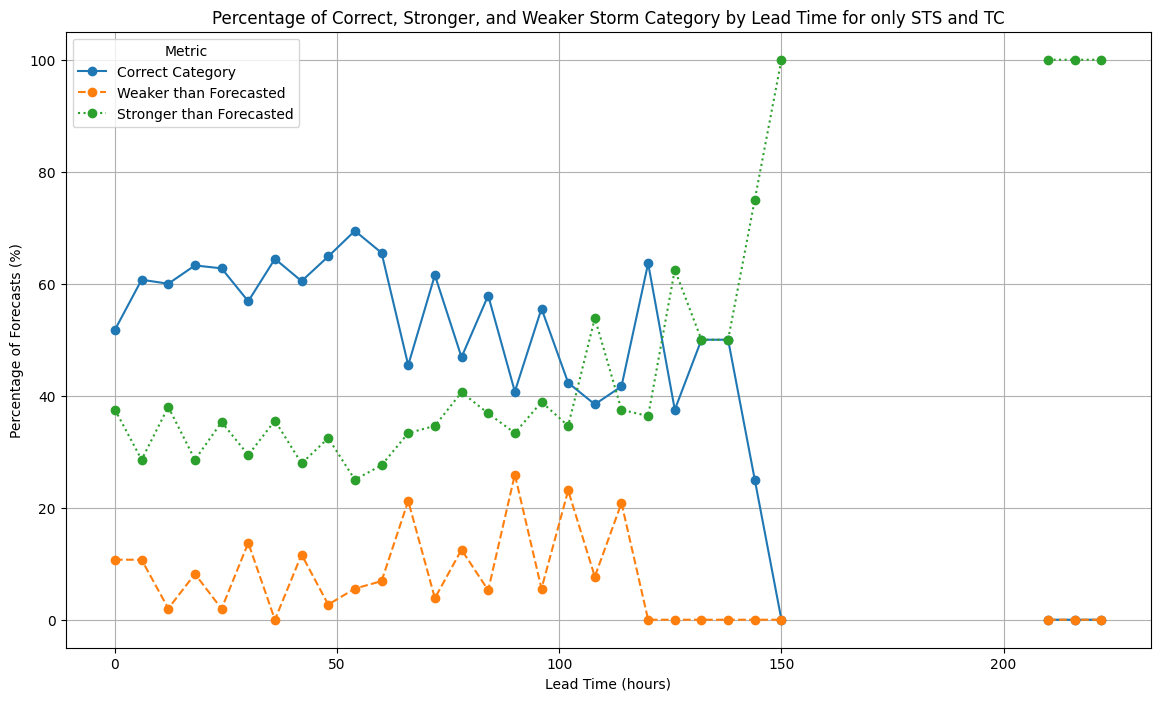

In [19]:
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

combined_metrics["percent_correct"] = (
    combined_metrics["correct_category"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_stronger"] = (
    combined_metrics["stronger_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)
combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot hit rate (Correct Category)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot miss rate (Weaker than Forecasted)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle="--",
    label="Weaker than Forecasted",
)

# Plot false alarm rate (Stronger than Forecasted)
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_stronger"],
    marker="o",
    linestyle=":",
    label="Stronger than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct, Stronger, and Weaker Storm Category by Lead Time for only STS and TC"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()

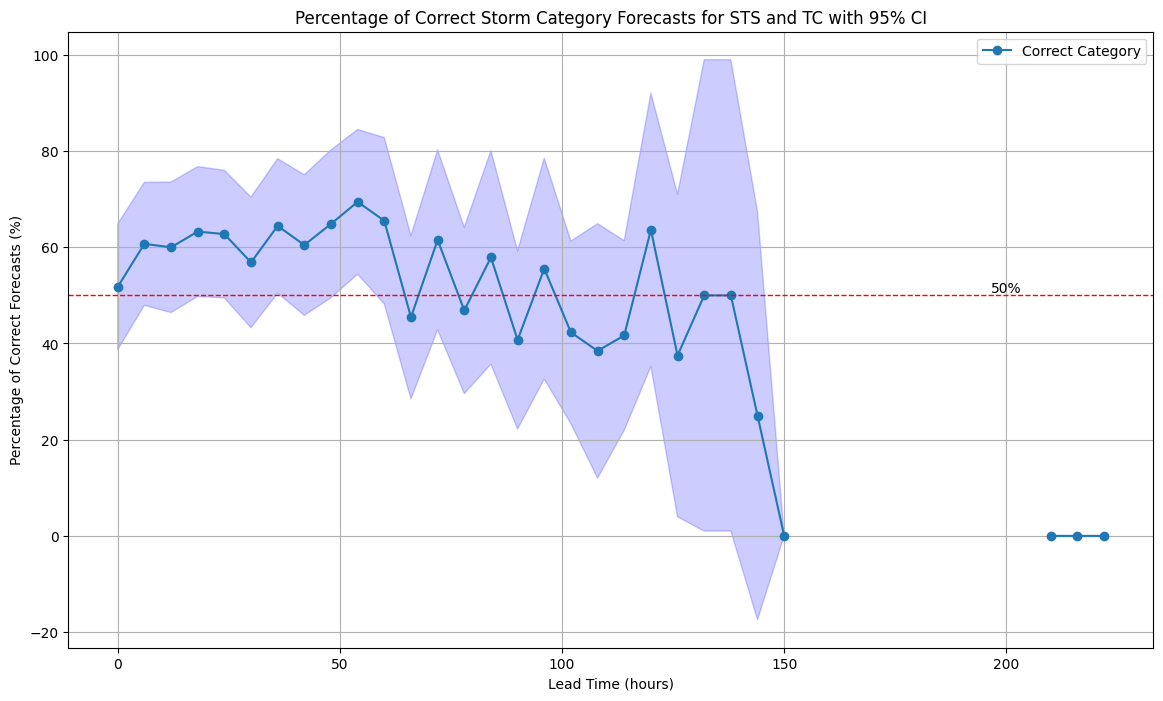

In [20]:
# Apply the confidence interval calculation
ci_results = combined_metrics.apply(
    lambda row: calculate_confidence_interval(
        row["correct_category"], row["total_cases"]
    ),
    axis=1,
)

# Unpack the results into separate columns
combined_metrics["ci_lower_correct"], combined_metrics["ci_upper_correct"] = (
    zip(*ci_results)
)

# Plot the 'Correct Category' with confidence intervals
plt.figure(figsize=(14, 8))

# Plot correct category
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_correct"],
    marker="o",
    label="Correct Category",
)

# Plot confidence interval
plt.fill_between(
    combined_metrics["lead_time"],
    combined_metrics["ci_lower_correct"],
    combined_metrics["ci_upper_correct"],
    color="blue",
    alpha=0.2,
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Correct Forecasts (%)")
plt.title(
    "Percentage of Correct Storm Category Forecasts for STS and TC with 95% CI"
)
plt.legend(title="")
plt.axhline(y=50, color="red", linestyle="--", linewidth=1)
plt.text(200, 50, "50%", color="black", ha="center", va="bottom")
plt.grid(True)
plt.show()

Comparing ECMWF and La Reunion forecasts against best track data

In [ ]:
combined_metrics = helpers.calculate_metrics_by_category_btdata_ecmwf(
    cyclone_tracks_sel,
    save_dir=save_dir,
    categorize_cyclone=categorize_cyclone,
    category_order=category_order,
    storm_category_filters=None,
    buffer_kms=None,
    longitude_cutoffs=None,
)
# Calculate total cases and percentages
combined_metrics = combined_metrics.groupby("lead_time").sum().reset_index()
combined_metrics["total_cases"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
    + combined_metrics["weaker_than_forecasted"]
)

# Combine correct and stronger than forecasted categories
combined_metrics["combined_correct_and_stronger"] = (
    combined_metrics["correct_category"]
    + combined_metrics["stronger_than_forecasted"]
)

# Calculate percentages for combined category
combined_metrics["percent_combined_correct_stronger"] = (
    combined_metrics["combined_correct_and_stronger"]
    / combined_metrics["total_cases"]
    * 100
)

combined_metrics["percent_weaker"] = (
    combined_metrics["weaker_than_forecasted"]
    / combined_metrics["total_cases"]
    * 100
)

# Plot the combined metrics
plt.figure(figsize=(14, 8))

# Plot combined correct and stronger than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_combined_correct_stronger"],
    marker="o",
    label="Correct or Stronger than Forecasted",
)

# Plot weaker than forecasted
plt.plot(
    combined_metrics["lead_time"],
    combined_metrics["percent_weaker"],
    marker="o",
    linestyle=":",
    label="Weaker than Forecasted",
)

# Add plot details
plt.xlabel("Lead Time (hours)")
plt.ylabel("Percentage of Forecasts (%)")
plt.title(
    "Percentage of Correct or Stronger, and Weaker Storm Category by Lead Time"
)
plt.legend(title="Metric")
plt.grid(True)
plt.show()